In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
%matplotlib inline

What stistics make sense for essay scoring? 
- Length of the essay
- Number of unique words (Repetetive information is unnecessary, just to prolong the essay)
- Complexity of the words (Shows understanding of the language), derivation might be tricky to do
- Length of the sentences (Too short - not adding anything, Too long - Unreadable)
- Spelling mistakes (Count / % of words) & Grammatical mistakes (Sub-Verb agreement, incorrect sentence structure etc.)
- Usage of entities ? (Not sure it matters but we can test it out. Entities such as Persons, organizations, locations etc. mostly towards student providing references)
- Usage of full spectrum of POS (Using adjectives, adverbs etc. shows grasp on language)
- Usage of correct punctuations 
- Repeated n-grams (If we can identify a way people usually reference statistics etc.)
- Usage of numbers / stats to add weight to the essay

In [2]:
essay_data  = pd.read_csv('./learning-agency-lab-automated-essay-scoring-2/train.csv')

In [3]:
essay_data.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [4]:
# Building a word cloud for the essays
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(str(essay_data[essay_data['score']>= 4]['full_text']))

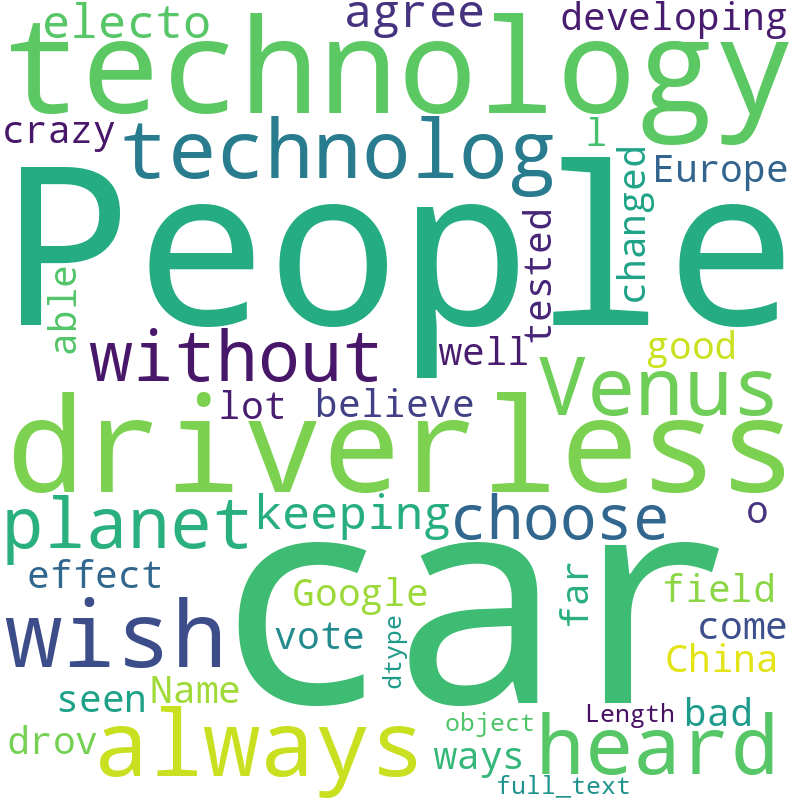

In [5]:
wordcloud.to_image()

In [6]:
# Building a word cloud for the essays
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(str(essay_data[essay_data['score']< 4]['full_text']))

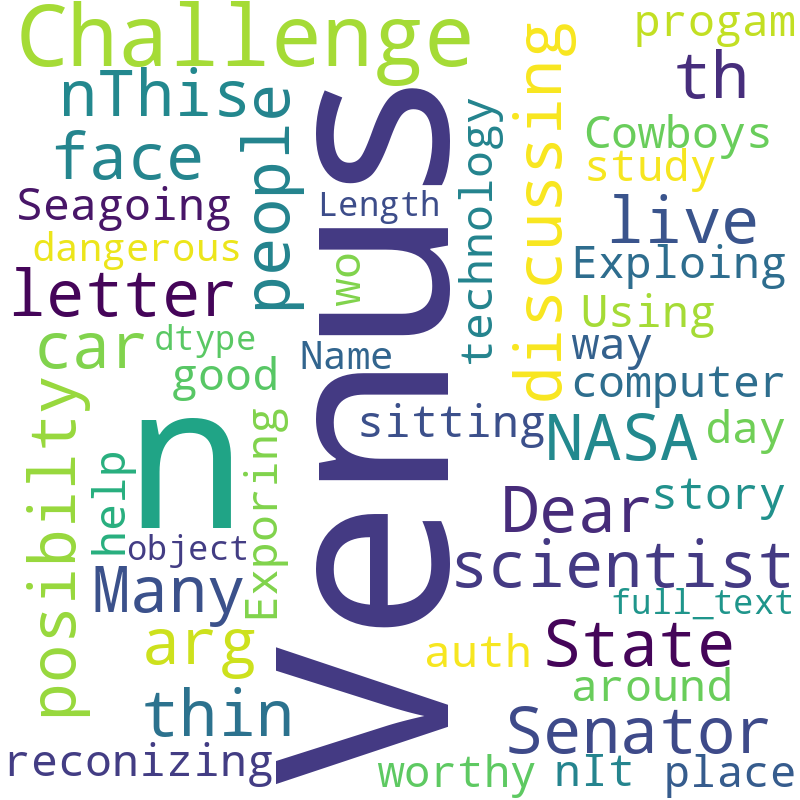

In [7]:
wordcloud.to_image()

In [8]:
from tqdm import tqdm
spacy.require_cpu
nlp = spacy.load('en_core_web_lg')

/home/giridhar/github/essay_scoring/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/giridhar/github/essay_scoring/.conda/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/giridhar/github/essay_scoring/.conda/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [9]:
nlp("xyz")

xyz

In [10]:
import torch

In [11]:

docs = list()
for doc in tqdm(nlp.pipe(essay_data['full_text'].values.tolist(), batch_size=100), total=len(essay_data)):
    # info = {
    #     "sents" : [sent.text for sent in doc.sents],
    #     "tokens" : [(token.text, token.lemma_, token.pos_, token.tag_, token.dep_) for token in doc],
    #     "ents" : [(ent.text, ent.label_) for ent in doc.ents],
    # }
    docs.append(doc)
    # torch.cuda.empty_cache()

100%|██████████| 17307/17307 [07:49<00:00, 36.85it/s]


In [14]:
essay_data['spacy_doc'] = docs

In [76]:
def get_number_of_sentences(doc):
    return len(list(doc.sents))

def get_number_of_unique_pos_tags(doc):
    return len(set([token.pos_ for token in doc]))

def get_number_of_unique_dep_tags(doc):
    return len(set([token.dep_ for token in doc]))
def get_number_of_unique_ents(doc):
    return len(set([ent.label_ for ent in doc.ents]))

def get_average_words_per_sentence(doc):
    return len(doc)/get_number_of_sentences(doc)

def get_percent_passive_sentences(doc):
    passive_sentences = [sent for sent in doc.sents if any(tok.dep_ == 'nsubjpass' for tok in sent)]
    return len(passive_sentences) / len(list(doc.sents)) * 100

def get_percent_simple_sentences(doc):
    simple_sentences = [sent for sent in doc.sents if len(list(sent.subtree)) <= 10]
    return len(simple_sentences) / len(list(doc.sents)) * 100

def get_percent_compound_sentences(doc):
    compound_sentences = [sent for sent in doc.sents if len(list(sent.subtree)) > 10 and len(list(sent.subtree)) <= 20]
    return len(compound_sentences) / len(list(doc.sents)) * 100

def get_percent_complex_sentences(doc):
    complex_sentences = [sent for sent in doc.sents if len(list(sent.subtree)) > 20]
    return len(complex_sentences) / len(list(doc.sents)) * 100

In [77]:
essay_data['number_of_sentences'] = essay_data['spacy_doc'].apply(get_number_of_sentences)
essay_data['number_of_unique_pos_tags'] = essay_data['spacy_doc'].apply(get_number_of_unique_pos_tags)
essay_data['number_of_unique_dep_tags'] = essay_data['spacy_doc'].apply(get_number_of_unique_dep_tags)
essay_data['number_of_unique_ents'] = essay_data['spacy_doc'].apply(get_number_of_unique_ents)
essay_data['length'] = essay_data['full_text'].str.len()
essay_data['num_words'] = essay_data['full_text'].str.split().str.len()
essay_data['num_unique_words'] = essay_data['full_text'].apply(lambda x: len(set(str(x).split())))
essay_data['average_words_per_sentence'] = essay_data['spacy_doc'].apply(get_average_words_per_sentence)
essay_data['percent_passive_sentences'] = essay_data['spacy_doc'].apply(get_percent_passive_sentences)
essay_data['percent_simple_sentences'] = essay_data['spacy_doc'].apply(get_percent_simple_sentences)
essay_data['percent_compound_sentences'] = essay_data['spacy_doc'].apply(get_percent_compound_sentences)
essay_data['percent_complex_sentences'] = essay_data['spacy_doc'].apply(get_percent_complex_sentences)


In [33]:
# Calculate the percentage-based features
essay_data['percent_unique_pos_tags'] = essay_data['number_of_unique_pos_tags'] / essay_data['num_words'] * 100
essay_data['percent_unique_dep_tags'] = essay_data['number_of_unique_dep_tags'] / essay_data['num_words'] * 100
essay_data['percent_unique_ents'] = essay_data['number_of_unique_ents'] / essay_data['num_words'] * 100
essay_data['percent_length'] = essay_data['length'] / essay_data['num_words'] * 100
essay_data['percent_unique_words'] = essay_data['num_unique_words'] / essay_data['num_words'] * 100

# Display the updated DataFrame
essay_data.head()

,essay_id,full_text,score,spacy_doc,number_of_sentences,number_of_unique_pos_tags,number_of_unique_dep_tags,number_of_unique_ents,length,num_words,num_unique_words,percent_unique_pos_tags,percent_unique_dep_tags,percent_unique_ents,percent_length,percent_unique_words
0,000d118,Many people have car where they live. The thin...,3,"(Many, people, have, car, where, they, live, ....",13,16,38,11,2677,498,253,3.212851,7.630522,2.208835,537.550201,50.803213
1,000fe60,I am a scientist at NASA that is discussing th...,3,"(I, am, a, scientist, at, NASA, that, is, disc...",21,15,36,6,1669,332,177,4.518072,10.843373,1.807229,502.710843,53.313253
2,001ab80,People always wish they had the same technolog...,4,"(People, always, wish, they, had, the, same, t...",24,14,34,1,3077,550,253,2.545455,6.181818,0.181818,559.454545,46.000000
3,001bdc0,"We all heard about Venus, the planet without a...",4,"(We, all, heard, about, Venus, ,, the, planet,...",21,16,39,6,2701,451,251,3.547672,8.647450,1.330377,598.891353,55.654102
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,"(Dear, ,, State, Senator, \n\n, This, is, a, l...",16,17,34,5,2208,373,162,4.557641,9.115282,1.340483,591.957105,43.431635


In [64]:
# train a XGBoost regression model using the features we have created
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from utils import compute_quadratic_weighted_kappa
import numpy as np
import textstat
from tqdm import tqdm
tqdm.pandas()


In [66]:
textstat.flesch_reading_ease(essay_data['full_text'][0])

57.98

In [65]:
essay_data['flesch_reading_ease'] = essay_data['full_text'].progress_apply(textstat.flesch_reading_ease)
essay_data['smog_index'] = essay_data['full_text'].progress_apply(textstat.smog_index)
essay_data['gunning_fog'] = essay_data['full_text'].progress_apply(textstat.gunning_fog)

100%|██████████| 17307/17307 [00:06<00:00, 2484.18it/s]


In [70]:
essay_data['number_of_sentences'].describe()

count    17307.000000
mean        19.414052
std          8.487259
min          1.000000
25%         13.000000
50%         18.000000
75%         24.000000
max        125.000000
Name: number_of_sentences, dtype: float64

In [78]:
# Compute the correlation matrix

corr_matrix = essay_data[['number_of_sentences','percent_unique_pos_tags', 'percent_unique_dep_tags', 'percent_unique_ents', 'percent_length',
                          'percent_unique_words','length','average_words_per_sentence','flesch_reading_ease','smog_index','percent_passive_sentences', 'percent_simple_sentences', 'percent_compound_sentences', 'percent_complex_sentences',
                          'gunning_fog', 'score']].corr()


# Apply a background gradient to the correlation matrix
corr_matrix_styled = corr_matrix.style.background_gradient(cmap='coolwarm')

# Display the styled DataFrame
corr_matrix_styled

,number_of_sentences,percent_unique_pos_tags,percent_unique_dep_tags,percent_unique_ents,percent_length,percent_unique_words,length,average_words_per_sentence,flesch_reading_ease,smog_index,percent_passive_sentences,percent_simple_sentences,percent_compound_sentences,percent_complex_sentences,gunning_fog,score
number_of_sentences,1.000000,-0.735068,-0.739639,-0.276418,-0.015426,-0.424184,0.729622,-0.369519,0.204646,-0.125428,-0.057234,0.253837,0.276919,-0.353252,-0.278699,0.584203
percent_unique_pos_tags,-0.735068,1.000000,0.970102,0.430476,0.001432,0.641833,-0.814123,-0.038686,0.094252,-0.201535,-0.096389,0.154923,0.081199,-0.145295,-0.020038,-0.682105
percent_unique_dep_tags,-0.739639,0.970102,1.000000,0.442161,0.010947,0.681104,-0.811960,-0.032608,0.078742,-0.174418,-0.041865,0.136846,0.077286,-0.132794,-0.012227,-0.676514
percent_unique_ents,-0.276418,0.430476,0.442161,1.000000,0.026709,0.510503,-0.326808,-0.056760,0.059962,-0.067345,0.002424,0.106815,0.050971,-0.096162,-0.042803,-0.350401
percent_length,-0.015426,0.001432,0.010947,0.026709,1.000000,0.062222,0.377725,0.053776,-0.101143,0.151318,0.054348,-0.039731,-0.022122,0.038301,0.031859,0.020113
percent_unique_words,-0.424184,0.641833,0.681104,0.510503,0.062222,1.000000,-0.514991,-0.106595,0.028213,-0.000953,-0.042450,0.152420,0.096067,-0.155901,-0.056985,-0.461523
length,0.729622,-0.814123,-0.811960,-0.326808,0.377725,-0.514991,1.000000,0.080623,-0.155321,0.272131,0.124889,-0.147108,-0.117613,0.170398,0.051018,0.648500
average_words_per_sentence,-0.369519,-0.038686,-0.032608,-0.056760,0.053776,-0.106595,0.080623,1.000000,-0.684549,0.345206,0.249477,-0.420410,-0.574585,0.677894,0.757139,-0.038108
flesch_reading_ease,0.204646,0.094252,0.078742,0.059962,-0.101143,0.028213,-0.155321,-0.684549,1.000000,-0.449187,-0.214084,0.313562,0.382785,-0.468963,-0.905474,-0.059611
smog_index,-0.125428,-0.201535,-0.174418,-0.067345,0.151318,-0.000953,0.272131,0.345206,-0.449187,1.000000,0.245345,-0.417094,-0.407209,0.542169,0.213829,0.206356


In [79]:
# Highligh only correlation with the score column
corr_matrix_styled = corr_matrix.style.background_gradient(cmap='coolwarm', subset=['score'])
corr_matrix_styled

,number_of_sentences,percent_unique_pos_tags,percent_unique_dep_tags,percent_unique_ents,percent_length,percent_unique_words,length,average_words_per_sentence,flesch_reading_ease,smog_index,percent_passive_sentences,percent_simple_sentences,percent_compound_sentences,percent_complex_sentences,gunning_fog,score
number_of_sentences,1.000000,-0.735068,-0.739639,-0.276418,-0.015426,-0.424184,0.729622,-0.369519,0.204646,-0.125428,-0.057234,0.253837,0.276919,-0.353252,-0.278699,0.584203
percent_unique_pos_tags,-0.735068,1.000000,0.970102,0.430476,0.001432,0.641833,-0.814123,-0.038686,0.094252,-0.201535,-0.096389,0.154923,0.081199,-0.145295,-0.020038,-0.682105
percent_unique_dep_tags,-0.739639,0.970102,1.000000,0.442161,0.010947,0.681104,-0.811960,-0.032608,0.078742,-0.174418,-0.041865,0.136846,0.077286,-0.132794,-0.012227,-0.676514
percent_unique_ents,-0.276418,0.430476,0.442161,1.000000,0.026709,0.510503,-0.326808,-0.056760,0.059962,-0.067345,0.002424,0.106815,0.050971,-0.096162,-0.042803,-0.350401
percent_length,-0.015426,0.001432,0.010947,0.026709,1.000000,0.062222,0.377725,0.053776,-0.101143,0.151318,0.054348,-0.039731,-0.022122,0.038301,0.031859,0.020113
percent_unique_words,-0.424184,0.641833,0.681104,0.510503,0.062222,1.000000,-0.514991,-0.106595,0.028213,-0.000953,-0.042450,0.152420,0.096067,-0.155901,-0.056985,-0.461523
length,0.729622,-0.814123,-0.811960,-0.326808,0.377725,-0.514991,1.000000,0.080623,-0.155321,0.272131,0.124889,-0.147108,-0.117613,0.170398,0.051018,0.648500
average_words_per_sentence,-0.369519,-0.038686,-0.032608,-0.056760,0.053776,-0.106595,0.080623,1.000000,-0.684549,0.345206,0.249477,-0.420410,-0.574585,0.677894,0.757139,-0.038108
flesch_reading_ease,0.204646,0.094252,0.078742,0.059962,-0.101143,0.028213,-0.155321,-0.684549,1.000000,-0.449187,-0.214084,0.313562,0.382785,-0.468963,-0.905474,-0.059611
smog_index,-0.125428,-0.201535,-0.174418,-0.067345,0.151318,-0.000953,0.272131,0.345206,-0.449187,1.000000,0.245345,-0.417094,-0.407209,0.542169,0.213829,0.206356


In [39]:
regressor = XGBRegressor()

In [80]:
X_train, X_temp, y_train, y_temp = train_test_split(essay_data[['number_of_sentences','percent_unique_pos_tags', 'percent_unique_dep_tags', 'percent_unique_ents', 'percent_length',
                          'percent_unique_words','length','average_words_per_sentence','flesch_reading_ease','smog_index', 'percent_passive_sentences', 'percent_simple_sentences', 'percent_compound_sentences', 'percent_complex_sentences',
                          'gunning_fog']], essay_data['score'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [81]:
regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [82]:
# Print feature importances with the column names
feature_importances = pd.DataFrame(regressor.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
length,0.344149
percent_unique_pos_tags,0.309368
percent_length,0.040404
percent_unique_words,0.035641
gunning_fog,0.030182
percent_unique_ents,0.028565
smog_index,0.026510
percent_complex_sentences,0.025545
percent_simple_sentences,0.025516
percent_compound_sentences,0.024289


In [83]:
# Check the model's performance on the test set for the root mean squared error & quadratic weighted kappa


y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
qwk = compute_quadratic_weighted_kappa(y_test, np.round(y_pred))
print(f"Quadratic Weighted Kappa: {qwk}")


Mean Squared Error: 0.4827366416355049
Quadratic Weighted Kappa: 0.7003583884625783


In [50]:
y_test

2595     3
4840     4
17206    3
14044    2
8991     4
        ..
16314    2
14393    2
7403     3
4929     2
2286     4
Name: score, Length: 2597, dtype: int64